In [1]:
# In my data 1 means the "Team"/ Home team won
import pandas as pd
from sklearn.model_selection import train_test_split
stats = pd.read_csv("rolling stats.csv")
X = stats.drop(columns=["Date", "Team", "Opp", "Win"])
y = stats["Win"]
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)


In [2]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

estimators = [("clf", XGBClassifier(random_state=8))]
pipe = Pipeline(estimators)


In [3]:
from skopt.space import Real, Integer
from skopt import BayesSearchCV
# Tuning hyperparameters for XGBoost using BayesSearchCV
search_space = {
    "clf__max_depth": Integer(2, 8),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0),
    "clf__n_estimators": Integer(100, 1000)
}

opt = BayesSearchCV(pipe, search_space, n_iter=50, cv=5, scoring="roc_auc", random_state=8)

In [4]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [5]:
opt.score(X_test, y_test)

np.float64(0.6686249376913764)

<Figure size 2000x1000 with 0 Axes>

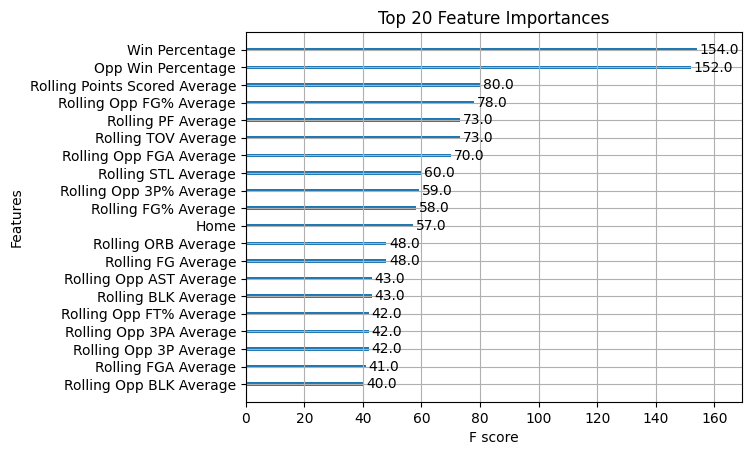

In [6]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
opt.predict_proba(X_test)
xgboost_step = opt.best_estimator_.named_steps["clf"]
xgboost_model = xgboost_step.get_booster()

# Plotting feature importance
plt.figure(figsize=(20, 10)) 
plot_importance(
    xgboost_model,
    max_num_features=20,
    importance_type="weight"  
)
plt.title("Top 20 Feature Importances")
plt.show()

In [7]:
import datetime
games_to_predict = pd.read_csv("games to predict.csv")
data = games_to_predict.drop(columns=["Date", "Team", "Opp"])
predictions = opt.predict_proba(data)
predictions = pd.DataFrame(predictions, columns=["Loss", "Win"])

games_to_predict['Win Probability'] = predictions['Win']

# Determining the predicted winner
games_to_predict['Predicted Winner'] = games_to_predict.apply(lambda row: row['Team'] if row['Win Probability'] > 0.5 else row['Opp'], axis=1)
games_to_predict[['Team', 'Opp', 'Win Probability', 'Predicted Winner', "Date"]].to_csv("Latest Predictions.csv", index=False)
